**Install Dependencies**

In [1]:
# %%capture
# !pip install -U fastai diffusers transformers jupyter huggingface-hub;

**Check diffusers version**

In [2]:
import diffusers
diffusers.__version__

'0.6.0'

In [3]:
from pathlib import Path
import hashlib
import json

from PIL import Image
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline

import logging
logging.disable(logging.WARNING)

In [4]:
from transformers import CLIPTextModel, CLIPTokenizer

from diffusers import AutoencoderKL, UNet2DConditionModel

from diffusers import LMSDiscreteScheduler

In [5]:
from tqdm.auto import tqdm

from fastai.callback.schedule import *

**Log into Hugging Face Hub**

1. Generate a user access token: [Access Tokens](https://huggingface.co/settings/tokens)
2. Paste your token when prompted after running the code cell below.

In [6]:
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

**Verify cached token**

In [7]:
!ls ~/.huggingface

token


**Accept Model License**

The Stable Diffusion checkpoints are available under the [CreativeML OpenRail-M license](https://huggingface.co/spaces/CompVis/stable-diffusion-license). The license claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. Open the Model Card pages below and accept the license agreement to download the pretrained models.. 


If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* [**Stable Diffusion v1-4 Model Card**](https://huggingface.co/CompVis/stable-diffusion-v1-4)
* [**Stable Diffusion v1-5 Model Card**](https://huggingface.co/runwayml/stable-diffusion-v1-5)

**Select a model**

In [8]:
# model_name = "CompVis/stable-diffusion-v1-4"
model_name = "runwayml/stable-diffusion-v1-5"

**Load tokenizer**

In [9]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)

**Load text encoder**

In [10]:
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

**Load autoencoder**

In [11]:
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", torch_dtype=torch.float16).to("cuda")

# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")
# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")

**Load unet**

In [12]:
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", torch_dtype=torch.float16).to("cuda")

**Define noise scheduler**

In [13]:
beta_start = 0.00085
beta_end = 0.012

In [14]:
scheduler = LMSDiscreteScheduler(beta_start=beta_start, 
                                 beta_end=beta_end, 
                                 beta_schedule="scaled_linear", 
                                 num_train_timesteps=1000)

**Define method to tokenizer and encode text**

In [15]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

**Define method to convert output tensor to image**

In [16]:
def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

**Define method to save image with unique file name**

In [17]:
def save_img(image, save_dir, fmt='PNG'):
    img_hash = hashlib.sha256(np.array(image)).hexdigest()[:24]
    image.save(f"{save_dir}/{img_hash}.{fmt.lower()}", format=fmt)
    return img_hash

**Define method to pipeline config used to generate an image**

In [18]:
def save_pipe_config(img_name, pipe_config, save_dir):
    with open(f"{save_dir}/{img_name}.json", "w") as write_file:
        json.dump(pipe_config, write_file)

**Define method to perform text2img**

In [19]:
def mk_samples(prompts, 
               negative_prompt="",
               height=512,
               width=512, 
               g=10,  
               steps=70, 
               guidance_sched=sched_lin,
               generator=None):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([negative_prompt] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
        
    latents_shape = (bs, unet.in_channels, height//8, width//8)
    latents = torch.randn(latents_shape, generator=generator, device='cuda', dtype=emb.dtype)
    
    # Set number of time steps for diffusion process
    scheduler.set_timesteps(steps)
    # Initialize noisy latents
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        
        # Guidance Annealing
        # https://forums.fast.ai/t/lesson-10-official-topic/101171/103
        g_current = guidance_sched(g, 0, i/steps)
        pred_nonscaled= u + g_current*(t-u)/torch.norm(t-u)*torch.norm(u)
        pred = pred_nonscaled * torch.norm(u)/torch.norm(pred_nonscaled)
        
        latents = scheduler.step(pred, ts, latents).prev_sample
        torch.cuda.empty_cache()

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

**Define directory to store generated images**

In [20]:
output_dir = Path("./output_dir")
output_dir.mkdir(parents=True, exist_ok=True)
output_dir

Path('output_dir')

**Define method to display grid of images**

In [21]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

**Define text prompt**

In [22]:
prompt = "A professional digital painting of a robot giving a thumbs up, gorgeous digital painting, warm colors, captivating, trending in artstation"
prompts = [prompt]
prompt

'A professional digital painting of a robot giving a thumbs up, gorgeous digital painting, warm colors, captivating, trending in artstation'

**Define negative prompt**

In [23]:
negative_prompt = "lowres, bad, error, blurry, compressed, incomplete"
negative_prompt

'lowres, bad, error, blurry, compressed, incomplete'

**Initialize random number generator for consistent images**

In [24]:
generator = torch.Generator(device='cuda')
generator.manual_seed(100)

**Define pipe config**

In [25]:
pipe_config = {}
pipe_config['model'] = model_name
pipe_config['prompt'] = prompt
pipe_config['negative_prompt'] = negative_prompt
pipe_config['height'] = 512
pipe_config['width'] = 512
pipe_config['steps'] = 70
pipe_config['guidance'] = 0.2
pipe_config['init_seed'] = generator.initial_seed()
pipe_config['generator_state'] = [int(i) for i in generator.get_state()]
pd.DataFrame.from_dict(pipe_config, orient='index')

,0
model,runwayml/stable-diffusion-v1-5
prompt,"A professional digital painting of a robot giving a thumbs up, gorgeous digital painting, warm colors, captivating, trending in artstation"
negative_prompt,"lowres, bad, error, blurry, compressed, incomplete"
height,512
width,512
steps,70
guidance,0.2
init_seed,100
generator_state,"[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, ...]"


**Optional: Load a config file to recreate a specific image**

In [26]:
# config_path = Path(output_dir/"601216c177aa0ab64546b968.json")

In [27]:
# with open(config_path) as f:
#     pipe_config = json.load(f)
#     generator_state = torch.tensor(pipe_config['generator_state'], dtype=torch.uint8)
#     generator.manual_seed(pipe_config['init_seed'])
#     generator.set_state(generator_state)
# pd.DataFrame.from_dict(pipe_config, orient='index')

**Specify number of images to generate**

In [28]:
num_images = 1

**Generate images**

  0%|          | 0/70 [00:00<?, ?it/s]

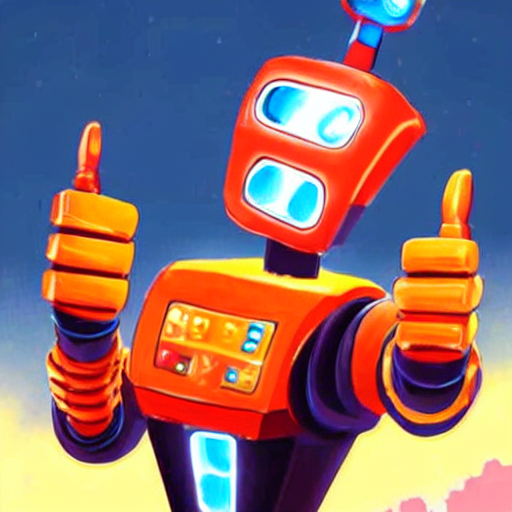

In [29]:
all_images = []
generator_states = []

for i in range(num_images):
    img_tensors = mk_samples(prompts=[pipe_config['prompt']], 
                    negative_prompt=pipe_config['negative_prompt'],
                    height=pipe_config['height'],
                    width=pipe_config['width'], 
                    g=pipe_config['guidance'], 
                    steps=pipe_config['steps'],
                    guidance_sched=sched_cos,
                    generator=generator)
    generator_states.append([int(i) for i in generator.get_state()])
    all_images.extend([mk_img(t) for t in img_tensors])
    torch.cuda.empty_cache()
    
for i, image in enumerate(all_images):
    img_name = save_img(image, save_dir=output_dir)
    save_pipe_config(img_name=img_name, pipe_config=pipe_config, save_dir=output_dir)
    pipe_config['generator_state'] = generator_states[i]

image_grid(all_images, num_images, 1)